In [87]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL

from imagecorrection.Airlight import Airlight
from imagecorrection.BoundCon import BoundCon
from imagecorrection.CalTransmission import CalTransmission
from imagecorrection.removeHaze import removeHaze
import glob

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from PIL import Image, ImageEnhance



In [88]:

labels = open(r'..\yolo-coco-data\coco.names').read().strip().split('\n')
weights_path = r'..\yolo-coco-data\yolov4.weights'
configuration_path = r'..\yolo-coco-data\yolov4.cfg'
probability_minimum = 0.5
threshold = 0.3


In [89]:
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)
layers_names_all = network.getLayerNames()
layers_names_output = [layers_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()] 

In [90]:
def detect_model(image_input, mode):
    blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    # Check point
    blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
    network.setInput(blob)  # setting blob as input to the network
    output_from_network = network.forward(layers_names_output)
    np.random.seed(42)
    colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')
    bounding_boxes = []
    confidences = []
    class_numbers = []
    image_input_shape = image_input.shape
    h, w = image_input_shape[:2]
    for result in output_from_network:
        for detection in result:
            scores = detection[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]
            if confidence_current > probability_minimum:
                box_current = detection[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)
    pred_scores = []
    mean_avg_prec = 0
    obj_mean_avg = 0
    if len(results) > 0:
        for i in results.flatten():
            pred_scores.append(confidences[i])
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            colour_box_current = [int(j) for j in colours[class_numbers[i]]]
            cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),colour_box_current, 3)
            cv2.putText(image_input, mode, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    if len(pred_scores) > 0:
        mean_avg_prec = sum(pred_scores)/len(results)
        obj_mean_avg = len(results) * mean_avg_prec
    return image_input, "Mean Average precision : {}".format(mean_avg_prec), "detected objects: {}".format(len(results)), obj_mean_avg


# Taking image path and reading the image

In [91]:
# load image from disk
image_path = r'..\images-for-testing\foggy-002.jpg'
file_name = image_path.split('\\')[-1]
image_input = plt.imread(image_path)


# detecting objects in orginal image

detected objects: 2
Mean Average precision : 0.8653043508529663


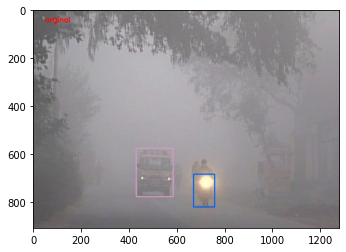

In [92]:
select_best_img = {}

# plt.figure(figsize=(15.0,15.0))
orginal = detect_model(image_input, "orginal")
dect = orginal[0]
select_best_img["orginal"] = orginal[3]
print(orginal[2])
print(orginal[1])
plt.imshow(dect)

In [93]:
im = Image.open(image_path)

# Adding Darkness to the image

detected objects: 3
Mean Average precision : 0.8078070878982544


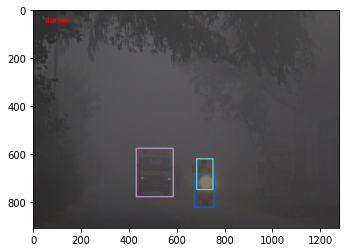

In [94]:
enhancer = ImageEnhance.Brightness(im)
factor =  0.5 #darkens the image
im_output_d = enhancer.enhance(factor)
# plt.figure(figsize=(15.0,15.0))
darken = detect_model(np.array(im_output_d), "darken")
dect_d = darken[0]
select_best_img["darken"] = darken[3]
print(darken[2])
print(darken[1])
plt.imshow(dect_d)

# Adding Brightness to the image

detected objects: 3
Mean Average precision : 0.8099384307861328


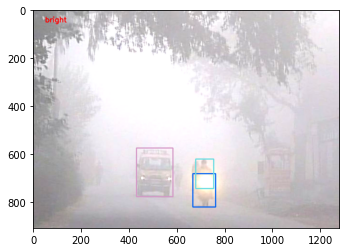

In [95]:
enhancer = ImageEnhance.Brightness(im)
factor = 1.5 #brightens the image
im_output_b = enhancer.enhance(factor)
# plt.figure(figsize=(15.0,15.0))
bright = detect_model(np.array(im_output_b), "bright")
dect_b = bright[0]
select_best_img["bright"] = bright[3]
print(bright[2])
print(bright[1])
plt.imshow(dect_b)

# Adding sharpness to the image

detected objects: 2
Mean Average precision : 0.8711980283260345


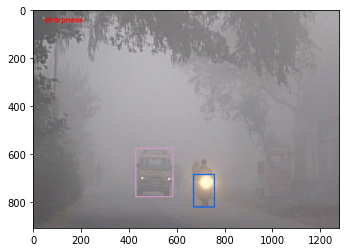

In [96]:
enhancer = ImageEnhance.Sharpness(im)
factor = 2
img_shrp = enhancer.enhance(factor)
# plt.figure(figsize=(15.0,15.0))
sharp = detect_model(np.array(img_shrp), "sharpness")
dect_s = sharp[0]
select_best_img["sharpness"] = sharp[3]
print(sharp[2])
print(sharp[1])
plt.imshow(dect_s)

# Adding Contrast to the image

detected objects: 3
Mean Average precision : 0.8327457110087076


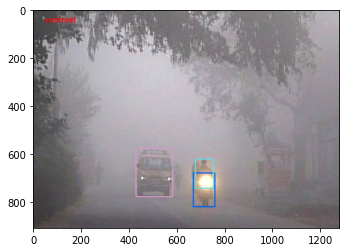

In [97]:
enhancer = ImageEnhance.Contrast(im)
factor = 1.5 #increase contrast
im_output_c = enhancer.enhance(factor)
# plt.figure(figsize=(15.0,15.0))
contrast = detect_model(np.array(im_output_c), "contrast")
dect_c = contrast[0]
select_best_img["contrast"] = contrast[3]
print(contrast[2])
print(contrast[1])
plt.imshow(dect_c)

# Adding darkness and sharpness to the image


detected objects: 3
Mean Average precision : 0.8163517713546753


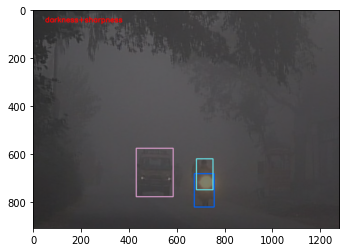

In [98]:
enhancer = ImageEnhance.Sharpness(im_output_d)
factor = 2
img_dshrp = enhancer.enhance(factor)
# plt.figure(figsize=(15.0,15.0))
dark_sharp = detect_model(np.array(img_dshrp), "darkness+sharpness")
dect_ds = dark_sharp[0]
select_best_img["darkness+sharpness"] = dark_sharp[3]
print(dark_sharp[2])
print(dark_sharp[1])
plt.imshow(dect_ds)

# Adding Brightness and Sharpness to the image

detected objects: 3
Mean Average precision : 0.8140221039454142


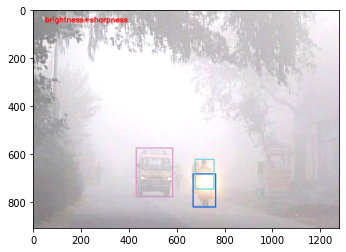

In [99]:
enhancer = ImageEnhance.Sharpness(im_output_b)
factor = 2
img_bshrp = enhancer.enhance(factor)
# plt.figure(figsize=(15.0,15.0))
bright_sharp = detect_model(np.array(img_bshrp), "brightness+sharpness")
dect_bs = bright_sharp[0]
select_best_img["brightness+sharpness"] = bright_sharp[3]
print(bright_sharp[2])
print(bright_sharp[1])
plt.imshow(dect_bs)

# Adding Contrast and Sharpness to the image

detected objects: 3
Mean Average precision : 0.8464691638946533


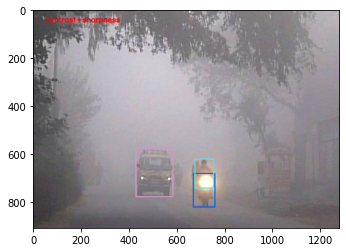

In [100]:
enhancer = ImageEnhance.Sharpness(im_output_c)
factor = 2
img_cshrp = enhancer.enhance(factor)
# plt.figure(figsize=(15.0,15.0))
const_sharp = detect_model(np.array(img_cshrp), "contrast+sharpness")
dect_cs = const_sharp[0]
select_best_img["contrast+sharpness"] = const_sharp[3]
print(const_sharp[2])
print(const_sharp[1])
plt.imshow(dect_cs)

# Adding brightness and contrast to the image

detected objects: 3
Mean Average precision : 0.7710428436597189


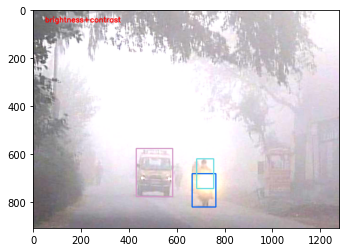

In [101]:
enhancer = ImageEnhance.Contrast(im_output_b)
factor = 1.5 #increase contrast
im_output_bc = enhancer.enhance(factor)
# plt.figure(figsize=(15.0,15.0))
bright_const = detect_model(np.array(im_output_bc), "brightness+contrast")
dect_bc = bright_const[0]
select_best_img["brightness+contrast"] = bright_const[3]
print(bright_const[2])
print(bright_const[1])
plt.imshow(dect_bc)

# Adding Color to the image

detected objects: 2
Mean Average precision : 0.8655649721622467


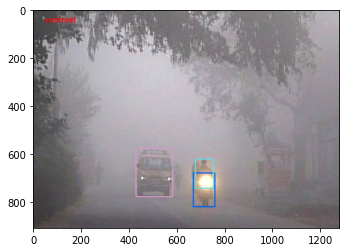

In [102]:
enhancer = ImageEnhance.Color(im)
factor = 1.5
im_output_color = enhancer.enhance(factor)
# plt.figure(figsize=(15.0,15.0))
color = detect_model(np.array(im_output_color), "color")
dect_color = contrast[0]
select_best_img["color"] = color[3]
print(color[2])
print(color[1])
plt.imshow(dect_color)

# Dehazing The Image

detected objects: 1
Mean Average precision : 0.7757204174995422
0.7757204174995422


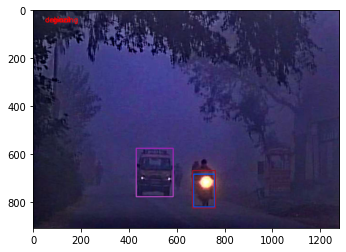

In [103]:
# dehazing according to recommended paper
windowSze = 15
AirlightMethod = 'fast'
A = Airlight(image_input, AirlightMethod, windowSze)
windowSze = 3
C0 = 20         # Default value = 20 (as recommended in the paper)
C1 = 300        # Default value = 300 (as recommended in the paper)
Transmission = BoundCon(image_input, A, C0, C1, windowSze) 
# Refine estimate of transmission
regularize_lambda = 1       # Default value = 1 (as recommended in the paper)
sigma = 0.5
Transmission = CalTransmission(image_input, Transmission, regularize_lambda, sigma)
# plt.figure(figsize=(15.0,15.0))
HazeCorrectedImg = removeHaze(image_input, Transmission, A, 0.85)
dehaze = detect_model(HazeCorrectedImg, "dehazing")
dect1 = dehaze[0]
select_best_img["dehazing"] = dehaze[3]
print(dehaze[2])
print(dehaze[1])
print(dehaze[3])
plt.imshow(dect1)	


# showing the differnce of image each enhancment in grid format

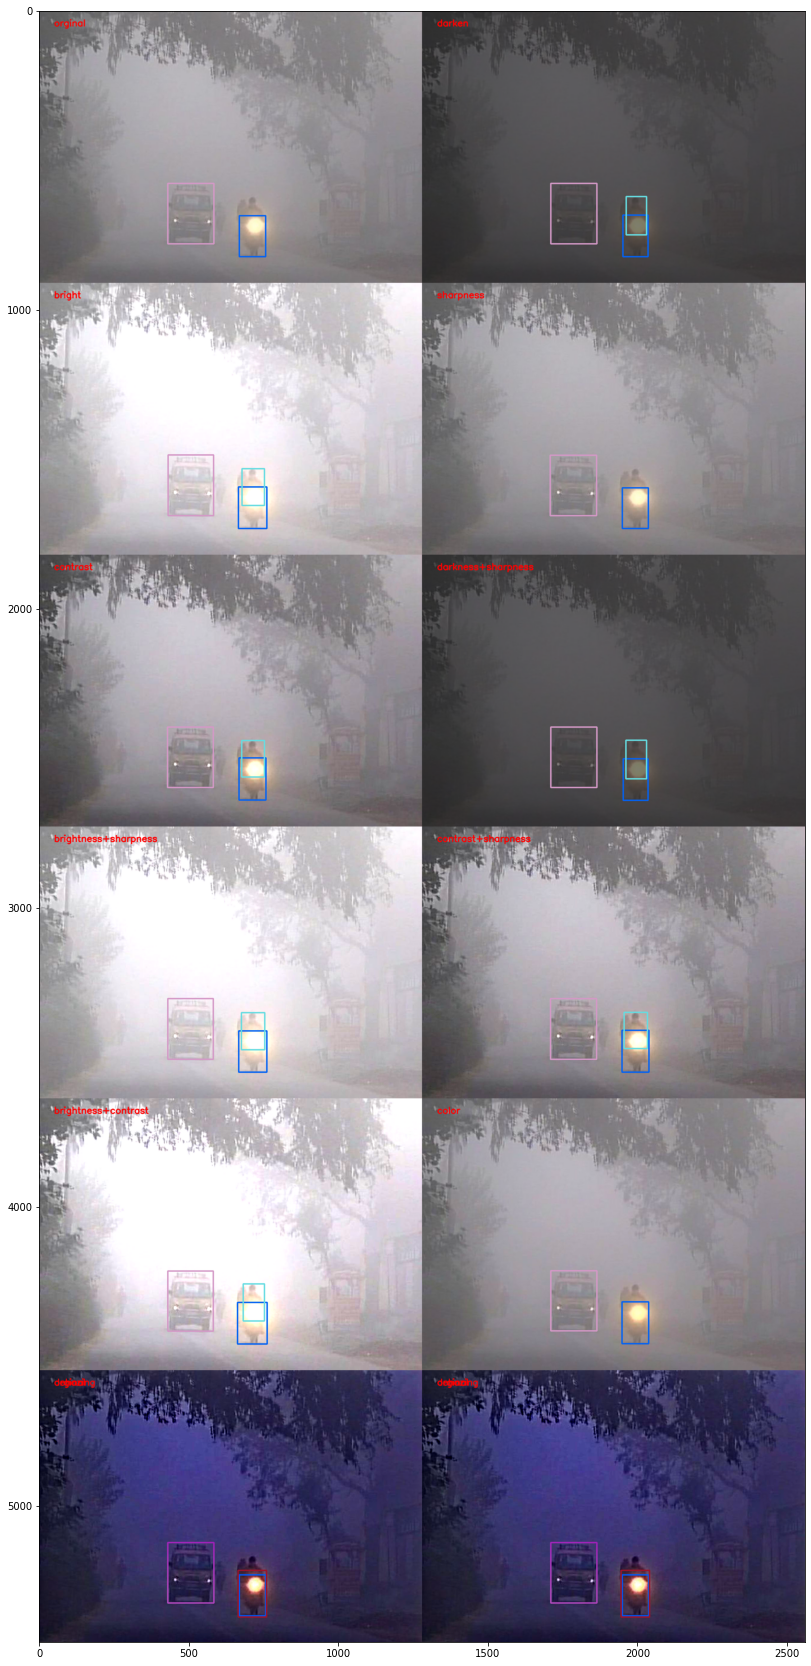

In [104]:
plt.figure(figsize=(30,30))
plt.imshow(np.vstack((np.hstack((orginal[0], darken[0])),
                      np.hstack((bright[0], sharp[0])),
                      np.hstack((contrast[0], dark_sharp[0])),
                      np.hstack((bright_sharp[0], const_sharp[0])),
                      np.hstack((bright_const[0], color[0])),
                      np.hstack((dehaze[0], dehaze[0])))))

# Best Image

The contrast+sharpness image is better for object detection
detected objects: 3
Mean Average precision : 0.8464691638946533


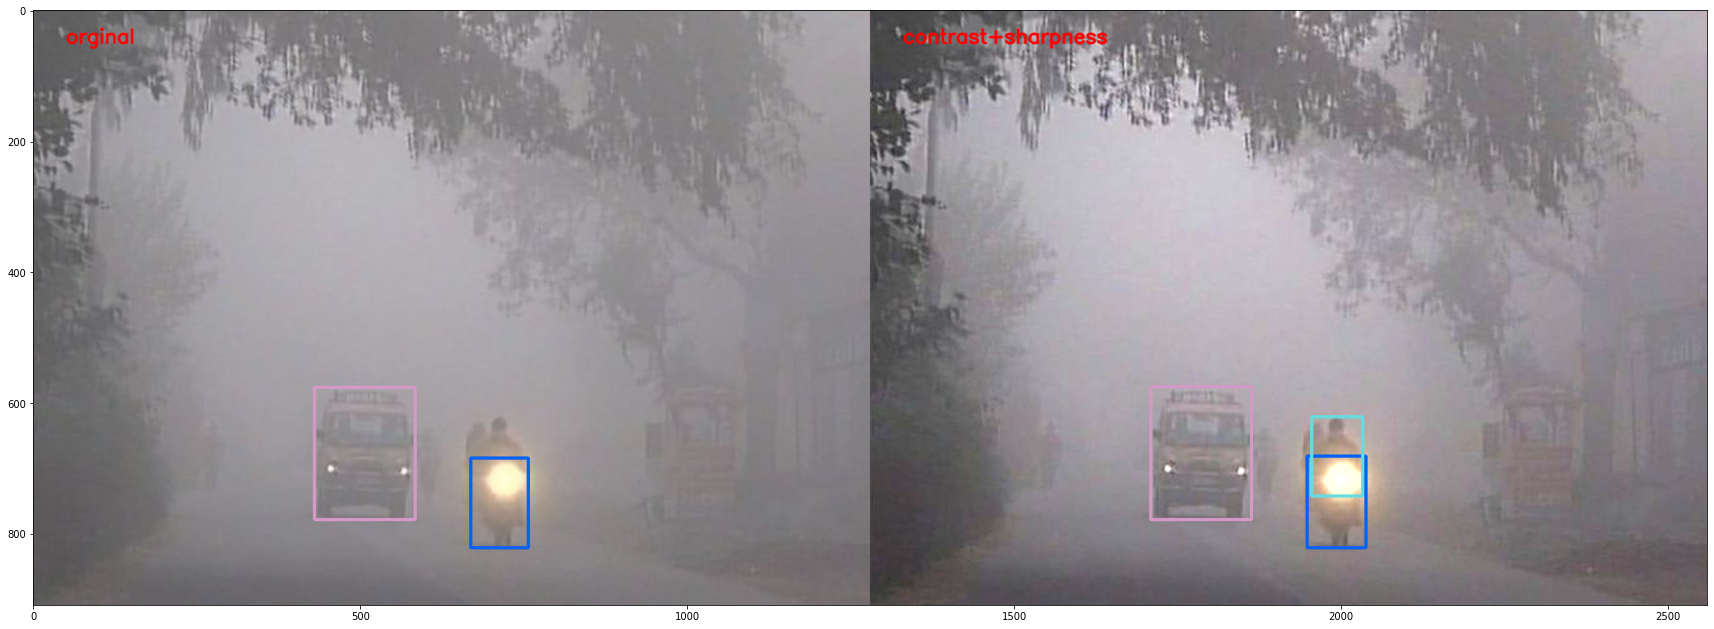

In [105]:
better_dect = max(select_best_img, key=select_best_img.get)
print("The {} image is better for object detection".format(better_dect))
best_img_path = r"..\results\{}".format(file_name)
# plt.figure(figsize=(15.0,15.0))
if not better_dect:
    print('no object is dected in given image')
elif better_dect == 'orginal':
    print(orginal[2])
    print(orginal[1])
    plt.imshow(orginal[0])
    plt.imsave(best_img_path, orginal[0])
elif better_dect == 'darken':
    print(darken[2])
    print(darken[1])
    plt.figure(figsize=(30,30))
    plt.imshow(np.hstack((orginal[0], darken[0])))
    plt.imsave(best_img_path, darken[0])
elif better_dect == 'bright':
    print(bright[2])
    print(bright[1])
    plt.figure(figsize=(30,30))
    plt.imshow(np.hstack((orginal[0], bright[0])))
    plt.imsave(best_img_path, bright[0])
elif better_dect == 'sharpness':
    print(sharp[2])
    print(sharp[1])
    plt.figure(figsize=(30,30))
    plt.imshow(np.hstack((orginal[0], sharp[0])))
    plt.imsave(best_img_path, sharp[0])
elif better_dect == 'contrast':
    print(contrast[2])
    print(contrast[1])
    plt.figure(figsize=(30,30))
    plt.imshow(np.hstack((orginal[0], contrast[0])))
    plt.imsave(best_img_path, contrast[0])
elif better_dect == 'darkness+sharpness':
    print(dark_sharp[2])
    print(dark_sharp[1])
    plt.figure(figsize=(30,30))
    plt.imshow(np.hstack((orginal[0], dark_sharp[0])))
    plt.imsave(best_img_path, dark_sharp[0])
elif better_dect == 'brightness+sharpness':
    print(bright_sharp[2])
    print(bright_sharp[1])
    plt.figure(figsize=(30,30))
    plt.imshow(np.hstack((orginal[0], bright_sharp[0])))
    plt.imsave(best_img_path, bright_sharp[0])
elif better_dect == 'contrast+sharpness':
    print(const_sharp[2])
    print(const_sharp[1])
    plt.figure(figsize=(30,30))
    plt.imshow(np.hstack((orginal[0], const_sharp[0])))
    plt.imsave(best_img_path, const_sharp[0])
elif better_dect == 'brightness+contrast':
    print(bright_const[2])
    print(bright_const[1])
    plt.imshow(np.hstack((orginal[0], bright_const[0])))
    plt.imsave(best_img_path, bright_const[0])
elif better_dect == 'color':
    print(color[2])
    print(color[1])
    plt.imshow(np.hstack((orginal[0], color[0])))
    plt.imsave(best_img_path, color[0])
elif better_dect == 'dehazing':
    print(dehaze[2])
    print(dehaze[1])
    plt.imshow(np.hstack((orginal[0], dehaze[0])))
    plt.imsave(best_img_path, dehaze[0])

# Grad cam++

In [106]:

def grad_cam_plus(model, img,
                  layer_name="block5_conv3", label_name=None,
                  category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])
    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id==None:
                    category_id = np.argmax(predictions[0])
                if label_name:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)
    global_sum = np.sum(conv_output, axis=(0, 1, 2))
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant
    weights = np.maximum(conv_first_grad[0], 0.0)
    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)
    heatmap = np.maximum(grad_CAM_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return heatmap


def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img /= 255
    return img


def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    imgwithheat = Image.fromarray(superimposed_img)  
    return imgwithheat
    if return_array:
        return super

# Heat map generation

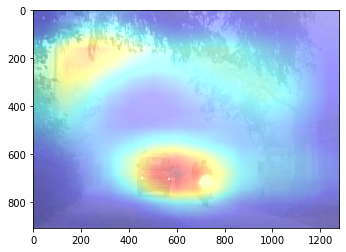

In [107]:
model_path = r'..\src\Gradcampp\model_weights\VGG16_MURA.h5'
model = load_model(model_path, compile=False)
img = preprocess_image(best_img_path)
heatmap_plus = grad_cam_plus(model, img)
heat_img = show_imgwithheat(image_path, heatmap_plus)
# plt.figure(figsize=(15.0,15.0))
plt.imshow(heat_img)
path_heat = r"..\results\heatmap_{}".format(file_name)
heat_img.save(path_heat)
